In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

import sys
import os
sys.path.append(os.path.abspath('../../'))

from src.Simplex.SimplexAlgorithm import simplex_predict, rolling_simplex_forecast
from src.Datasets.SyntheticDataset import SimplePeriodicDataset
from sklearn.metrics import mean_squared_error

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 1                               # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of time series
perc_of_past = 0.95                     # percentage of time series used for prediction

# Start and end point of time series that will be shown in the graph
start_idx = int(total_length - (total_length * ((1-perc_of_past) * 2)))
end_idx = int(total_length)

# Retrieve the same dataset as used for our Transformer with Multi Head Simplex Attention
dataset = SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

# Converts the data to be used with a pure Simplex Algorithm
X_step = []
X_vals = []
y_step = []
y_vals = []

for i in range(len(dataset)):
    stepX, X, stepy, y = dataset[i]
    X_step.append(stepX[-1].item())
    X_vals.append(X[-1].item())
    y_step.append(stepy[-1].item())
    y_vals.append(y[-1].item())

X_step = np.array(X_step)
X_vals = np.array(X_vals)
y_step = np.array(y_step)
y_vals = np.array(y_vals)

# Splitting in time series that the model can use to predict (seen) and time series to check the prediction (hidden/target)
past_time = X_vals[:int(perc_of_past * len(X_vals))]
true_future = y_vals[int(perc_of_past * len(y_vals)):]

Simplex MSE: 0.8394721506095235


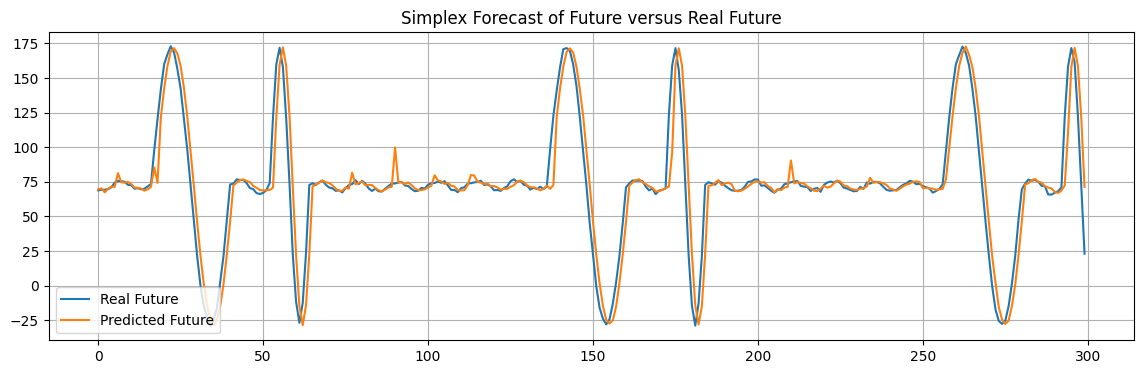

In [4]:
# Run the Simplex Algorithm to predict next # steps
steps = len(true_future)
predicted_future = rolling_simplex_forecast(X_vals, embedding_dim=4, k=4, steps=steps)

# Evaluation of predicted future versus real future
print("Simplex MSE:", mean_squared_error(true_future, predicted_future)/steps)

plt.figure(figsize=(14, 4))
plt.plot(true_future, label='Real Future')
plt.plot(predicted_future, label='Predicted Future')
plt.title("Simplex Forecast of Future versus Real Future")
plt.legend()
plt.grid(True)
plt.show()

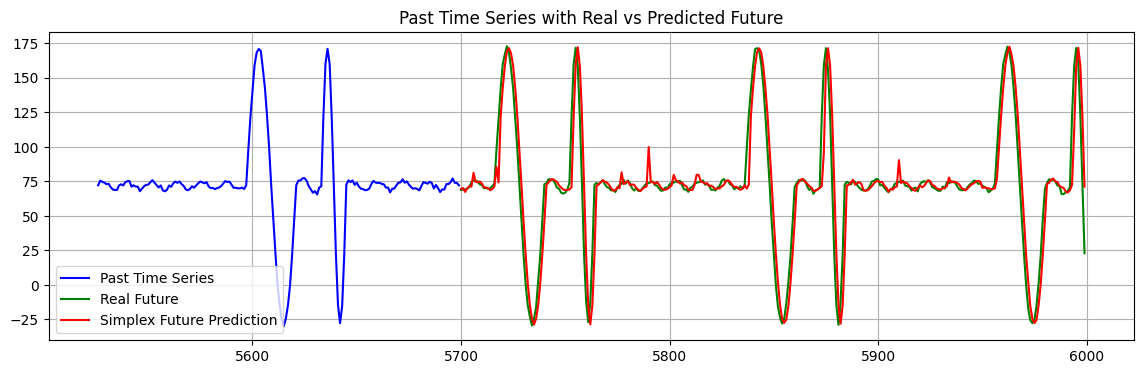

In [5]:
time_index = np.arange(len(X_step))
part_of_past_series = past_time[start_idx:]

plt.figure(figsize=(14, 4))
plt.plot(time_index[start_idx:len(past_time)], part_of_past_series, label='Past Time Series', color='blue')
plt.plot(time_index[len(past_time):len(past_time) + steps], true_future, label='Real Future', color='green')
plt.plot(time_index[len(past_time):len(past_time) + steps], predicted_future, label='Simplex Future Prediction', color='red')
plt.title("Past Time Series with Real vs Predicted Future")
plt.legend()
plt.grid(True)
plt.show()